# The bichromatic force

This example covers calculating the forces involved in the bichormatic force, or in the stimulated emission of light into two travelling wavepackets.  It attempts to replicate Fig. 1 of J. Söding, R. Grimm, Y. Ovchinnikov, P. Bouyer, and C. Salomon, Short-Distance Atomic Beam Deceleration with a Stimulated Light Force”, *Phys. Rev. Lett.* **78**, 1420 (1997) http://dx.doi.org/10.1103/PhysRevLett.78.1420

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pylcp
from IPython.display import HTML

### Define the problem

As always, the first step is to define the laser beams, magnetic field, and Hamiltonian.  The two level Hamiltonian here is the same as many others, like that in the [rapid adiabatic passage](../basics/04_adiabatic_passage.ipynb) and [two-level molasses](../molasses/00_two_level_1D_molasses.ipynb) examples.

Because we are dealing with a two state system addressable only with $\pi$ light, we keep the geometry pretty straight forward by having all lasers move along $\hat{x}$.  Note that because we have positive and negative frequencies about resonance, we will put the detuning on the lasers themselves, since the average detuning is zero.

The last thing to think about is the beat phase of the lasers.  I follow the phase convention of L. Aldridge, *The Bichromatic Force in Multi-Level Systems*, Ph.D. thesis, 2016.

In [2]:
# Make a method to return the lasers:
def return_lasers(delta, beta):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta, 'phase':-np.pi/8},
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':-delta, 'beta':beta, 'phase':np.pi/8},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta, 'phase':np.pi/8},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':-delta, 'beta':beta, 'phase':-np.pi/8},
        ], beam_type=pylcp.infinitePlaneWaveBeam)


# Standard two-level Hamiltonian:
Hg = np.array([[0.]])
He = np.array([[0.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0] = 1.

hamiltonian = pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q)

magField = lambda R: np.zeros(R.shape)

### Examine the phase

Let's specifically compare our electric field with Eq. 2.6 in L. Aldridge, *The Bichromatic Force in Multi-Level Systems*, Ph.D. thesis, 2016.  To do this, we first make the `laserBeams`, then divide them into the $+\hat{k}$ (rightward) and $-\hat{z}$ (leftward) going components.

In [3]:
delta = 39.
beta = 2*39**2

laserBeams = return_lasers(delta, beta)
laserBeams_rightward = pylcp.laserBeams(laserBeams.beam_vector[:2])
laserBeams_leftward = pylcp.laserBeams(laserBeams.beam_vector[2:])

Set up the figure for the animation.  We want to capture the output, hence the `%%capture` statement in this cell.  The output is just the figure we will draw the animation into.

In [4]:
%%capture
fig, ax = plt.subplots(1, 1)
line_thr, = ax.plot([], [], lw=1.0)
line_exp, = ax.plot([], [], lw=0.75, color='k', linestyle='--')

ax.set_ylim((-350, 350));
ax.set_xlim((-4*np.pi, 4*np.pi))
ax.set_xlabel('$kx$')
ax.set_ylabel('$E/E_0$')
x = np.linspace(-4*np.pi, 4*np.pi, 1001)

def init():
    line_thr.set_data([], [])
    line_exp.set_data([], [])
    return (line_thr, line_exp)

def animate(i):
    t = i/50*(np.pi/delta)
    #ax.plot(x, np.real(laserBeams_rightward.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    #ax.plot(x, np.real(laserBeams_leftward.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    line_thr.set_data(x, np.real(laserBeams.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    line_exp.set_data(x, 4*np.sqrt(2*beta)*np.real(np.cos(x)*np.cos(delta*t)*np.cos(np.pi/8)+1j*np.sin(x)*np.sin(delta*t)*np.sin(np.pi/8)))
    
    return (line_thr, line_exp)

Now make the animation.  The dashed lines are the expectation from Aldridge, and the solid is the result from `pylcp`.

In [5]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

HTML(anim.to_html5_video())

### Generate a force profile

Using the same parameters as Fig. 1 of the PRL.  We also use the same time-ending criteria as Aldridge.

In [6]:
delta = 39
betas = [2*39**2, 2*43**2, 2*47**2]

v = np.arange(-50., 50.1, 0.5)

obe ={}
for beta in betas:
    laserBeams = return_lasers(delta, beta)
    
    obe[beta] = pylcp.obe(laserBeams, magField, hamiltonian, transform_into_re_im=True)
    obe[beta].generate_force_profile(
        np.zeros((3,) + v.shape),
        [v, np.zeros(v.shape), np.zeros(v.shape)],
        name='molasses', progress_bar=True,
        deltat_func=lambda r, v: 2*np.pi*(np.amin([10., 1./(np.linalg.norm(v)+1e-9)]) + 200./delta),
        itermax=3, rel=1e-4, abs=1e-6
    )

Completed in 24:11.                                                 
Completed in 24:35.                                                 
Completed in 27:35.                                                 


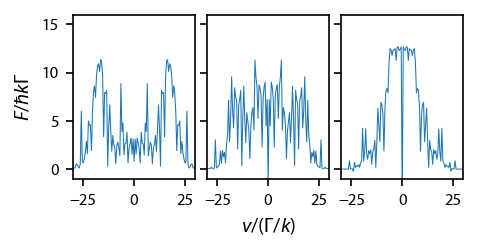

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(3.25, 1.5))
for ii, beta in enumerate(betas):
    ax[ii].plot(v, obe[beta].profile['molasses'].F[0], linewidth=0.5)
    ax[ii].set_ylim(-1, 16)
    ax[ii].set_xlim(-30, 30)

for ii in range(1, 3):
    ax[ii].yaxis.set_ticklabels('')
    
ax[0].set_ylabel('$F/\hbar k \Gamma$')
ax[1].set_xlabel('$v/(\Gamma/k)$')
fig.subplots_adjust(bottom=0.25)